In [1]:
# !pip install wget
# !pip install tables

In [2]:
# import os,sys

# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append("/content/drive/My Drive/Collab/collab_v1")
# %cd "/content/drive/My Drive/Collab/collab_v1"

In [3]:
# !pip install tensorflow


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

#some plotting routines
import plotting

# data processing
import data_higgs as dh

# %tensorflow_version
#import the working methods
import tensorflow as tf
print("TensorFlow version ",tf.__version__)

from tensorflow import keras
print("TF Keras version ",tf.keras.__version__)


from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

TensorFlow version  2.7.0
TF Keras version  2.7.0


In [5]:
#--------- globals

# Need to see a large portion of the data before we can build a layer, for
# example half of data n_batches_per_layer =  NBATCH_FRAC * NUM_EXAMPLES / BATCH_SIZE
BATCH_SIZE = 100

# Seed value
# Apparently you may use different seed values at each stage
SEED_VALUE= 10001
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED_VALUE)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(SEED_VALUE)

In [6]:
#-------- routines

def split_xy(rawdata):
    #split features and labels from data 
    #prepare the data => normalizations !   

    # split 
    data_y=rawdata['hlabel'] # labels only: 0.=bkg, 1.=sig
    data_x=rawdata.drop(['hlabel'], axis=1) # features only
    
    #now prepare the data
    mu = data_x.mean()
    s = data_x.std()
    dmax = data_x.max()
    dmin = data_x.min()

    # normal/standard rescaling 
    #data_x = (data_x - mu)/s

    # scaling to [-1,1] range
    #data_x = -1. + 2.*(data_x - dmin)/(dmax-dmin)

    # scaling to [0,1] range
    data_x = (data_x - dmin)/(dmax-dmin)


    return data_x,data_y

Loading /Users/greg/Documents/Šola/Faks/3 letnik/mpr/12 - ml/src/data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Shapes train:(360000, 18) and test:(40000, 18)


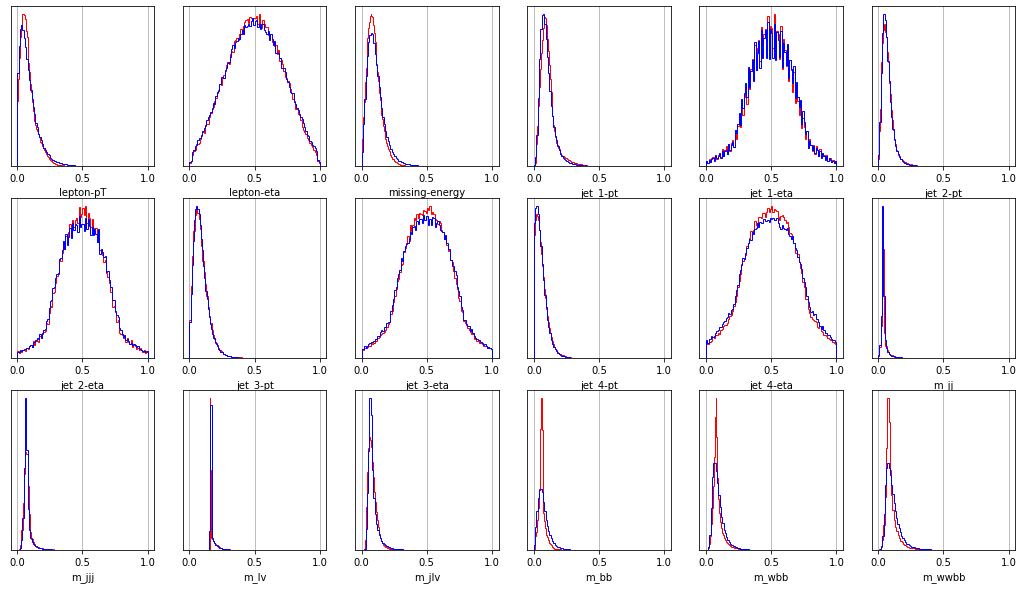

Steps train:3600 and test:400
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                950       
                                                                 
 dense_7 (Dense)             (None, 50)                2550      
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,551
Trainable params: 3,551
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
   1/3600 [..............................] - ETA: 18:59 - loss: 0.6726 - accuracy: 0.6400 - auc: 0.5840 -

2022-01-30 13:30:32.499891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3600/3600 [==============================] - ETA: 0s - loss: 0.6392 - accuracy: 0.6273 - auc: 0.6764 - binary_crossentropy: 0.6392

2022-01-30 13:31:04.172414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3600/3600 [==============================] - 34s 9ms/step - loss: 0.6392 - accuracy: 0.6273 - auc: 0.6764 - binary_crossentropy: 0.6392 - val_loss: 0.6207 - val_accuracy: 0.6527 - val_auc: 0.7111 - val_binary_crossentropy: 0.6207
Epoch 2/15
3600/3600 [==============================] - 34s 9ms/step - loss: 0.6069 - accuracy: 0.6692 - auc: 0.7309 - binary_crossentropy: 0.6069 - val_loss: 0.6020 - val_accuracy: 0.6730 - val_auc: 0.7376 - val_binary_crossentropy: 0.6020
Epoch 3/15
3600/3600 [==============================] - 33s 9ms/step - loss: 0.5926 - accuracy: 0.6825 - auc: 0.7477 - binary_crossentropy: 0.5926 - val_loss: 0.5919 - val_accuracy: 0.6819 - val_auc: 0.7498 - val_binary_crossentropy: 0.5919
Epoch 4/15
3600/3600 [==============================] - 33s 9ms/step - loss: 0.5829 - accuracy: 0.6906 - auc: 0.7582 - binary_crossentropy: 0.5829 - val_loss: 0.5843 - val_accuracy: 0.6887 - val_auc: 0.7581 - val_binary_crossentropy: 0.5843
Epoch 5/15
3600/3600 [=========================

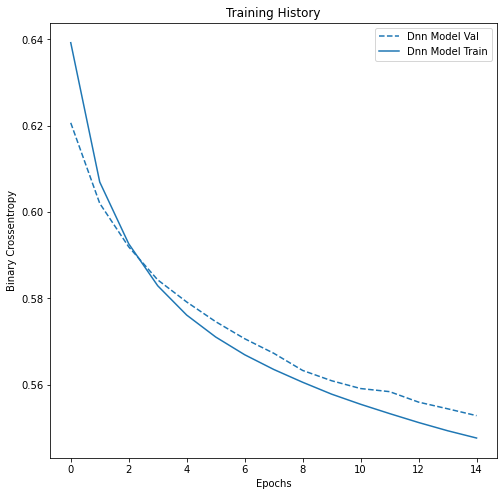

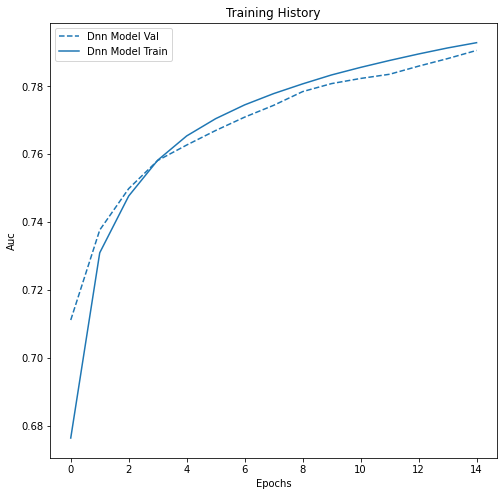

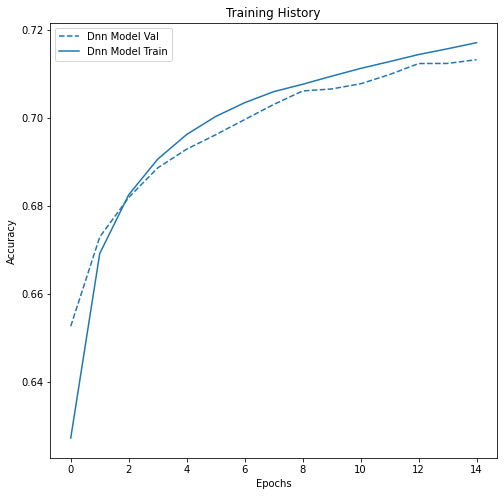

2022-01-30 13:38:43.362090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



AUC score: 0.7582180773230143


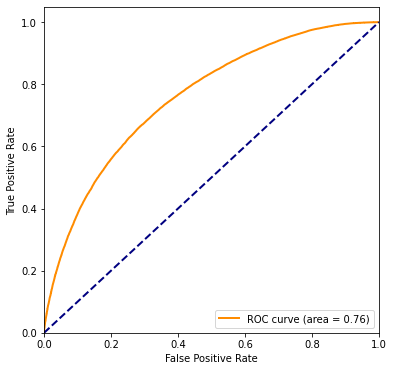

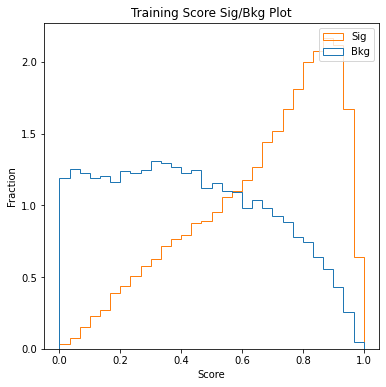

In [69]:
nepoch = 15
# Training progress and eval results are shown as logging.INFO; so enables it.

#needs to be done once if the h5 files need to be recreated...
#dh.download_and_make_data()

hdata=dh.load_data()
data_fnames=hdata['feature_names'].to_numpy()[1:] #drop labels
n_dims=data_fnames.shape[0]
print ("Entries read {} with feature names {}".format(n_dims,data_fnames))

x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample

print("Shapes train:{} and test:{}".format(x_train.shape,x_test.shape))

#plot distributions
plotting.plot_sig_bkg_from_np_arrays(x_train.to_numpy(),y_train.to_numpy(),data_fnames,logy=False)

# ready the data for TF
ds_train = tf.data.Dataset.from_tensor_slices((x_train.to_numpy(),y_train.to_numpy()))
ds_train = ds_train.repeat()
ds_train = ds_train.batch(BATCH_SIZE,drop_remainder=True)

ds_test = tf.data.Dataset.from_tensor_slices((x_test.to_numpy(),y_test.to_numpy()))
ds_test = ds_test.repeat()
ds_test = ds_test.batch(BATCH_SIZE,drop_remainder=True)

train_steps=int(x_train.shape[0]/BATCH_SIZE)
test_steps=int(x_test.shape[0]/BATCH_SIZE)
print("Steps train:{} and test:{}".format(train_steps,test_steps))

# build a model - a DNN in TF 2.0 
dnn = Sequential()
dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
dnn.add(Dense(1, activation='sigmoid')) # output layer/value
plot_model(dnn, to_file='dnn_model.png', show_shapes=True)

dnn.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy', 'AUC', 'binary_crossentropy'])

dnn.summary()

#optional early stopping
eval_metric = 'AUC'
earlystop_callback = EarlyStopping(
        mode='max',
        monitor='val_' + eval_metric,
        patience=5,
        min_delta=0.00001,
        verbose=1
    )

#run the training
dnn_model_history = dnn.fit(ds_train,
        epochs=nepoch,
        steps_per_epoch=train_steps,
        #callbacks=[earlystop_callback],
        validation_data=ds_test,
        validation_steps=test_steps
    )

#plot training history
print("history values",dnn_model_history.history.keys())
plotting.plot_history([('DNN model', dnn_model_history),],key='binary_crossentropy')
plotting.plot_history([('DNN model', dnn_model_history),],key='auc')
plotting.plot_history([('DNN model', dnn_model_history),],key='accuracy')

#plot & print results like ROC and score distribution etc...
y_score=dnn.predict(x_val.to_numpy())[:,0]
plotting.plot_roc(y_val,y_score, "DNN_best.pdf")
plotting.plot_score(y_val,y_score)
print()
auc=roc_auc_score(y_val,y_score)
print("AUC score: {}".format(auc))


['lepton-pT',
 'lepton-eta',
 'missing-energy',
 'jet_1-pt',
 'jet_1-eta',
 'jet_2-pt',
 'jet_2-eta',
 'jet_3-pt',
 'jet_3-eta',
 'jet_4-pt',
 'jet_4-eta',
 'm_jj',
 'm_jjj',
 'm_lv',
 'm_jlv',
 'm_bb',
 'm_wbb',
 'm_wwbb']

In [70]:
import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

i = 0
def score(X, y):
    global i
    i += 1
    print(i, 'iteration')
    y_pred = tf.round(dnn.predict(X)[:, 0])
    return (y == np.array(y_pred)).sum() / y.size
    # return accuracy(y, y_pred)


base_score, score_decreases = get_score_importances(score, np.array(x_test), np.array(y_test), n_iter=2)
feature_importances = np.mean(score_decreases, axis=0)

print(feature_importances)


1 iteration
2 iteration
3 iteration
4 iteration
5 iteration
6 iteration
7 iteration
8 iteration
9 iteration
10 iteration
11 iteration
12 iteration
13 iteration
14 iteration
15 iteration
16 iteration
17 iteration
18 iteration
19 iteration
20 iteration
21 iteration
22 iteration
23 iteration
24 iteration
25 iteration
26 iteration
27 iteration
28 iteration
29 iteration
30 iteration
31 iteration
32 iteration
33 iteration
34 iteration
35 iteration
36 iteration
37 iteration
[0.0202625 0.0066875 0.01645   0.0359625 0.00835   0.011625  0.0035625
 0.0035375 0.00185   0.003325  0.0015    0.0063375 0.01775   0.004525
 0.0157    0.1059375 0.0804625 0.0853875]


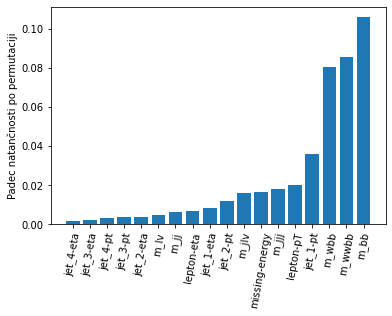

In [71]:
# print(base_score, score_decreases)

names = x_val.columns.values.tolist()
sorted_order = np.argsort(feature_importances)


plt.bar(np.array(names)[sorted_order], feature_importances[sorted_order])

# plt.xticks(names[sorted_order])
# names[sorted_order]
# np.array(names)names[sorted_order]
plt.xticks(rotation=80)
# plt.xlabel('Značilnost')
plt.ylabel('Padec natančnosti po permutaciji')

plt.savefig('../grafi/permutation_importance.pdf', bbox_inches='tight')
plt.show()